# インポート

In [94]:

import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認
import ydata_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

import sys

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
import japanize_matplotlib

from pathlib import Path

# Path().resolve()
# sys.path.append(os.path.join(Path().resolve(), '../source/'))

import seaborn as sns # Samuel Norman Seabornからとっている


## データ確認

In [95]:

df_train = pd.read_csv("../data/input/train.csv") # 学習データ
df_test = pd.read_csv("../data/input/test.csv")   # テストデータ

In [96]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* テストデータのAgeに欠損値が多い
    * テストデータを補完するのはよいのかわからないが補間を試みる

In [97]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


## Age

欠損値があるので補完する。
* 平均値で補完する場合

In [98]:
df_train["Age_fillna_mean"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train.loc[df_train["Age"].isnull(), ["Age", "Age_fillna_mean"]].head()

,Age,Age_fillna_mean
5,NaN,29.699118
17,NaN,29.699118
19,NaN,29.699118
26,NaN,29.699118
28,NaN,29.699118


* 持っているデータから推論する

In [109]:
# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
df_all = pd.concat([df_train, df_test], ignore_index=True, sort=False)
age_df = df_all[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df = pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
print(df_test.Age.isnull())
df_all.loc[(df_all.Age.isnull()), 'Age'] = predictedAges 
df_test = df_all[df_all['Survived'].isnull()].drop('Survived',axis=1)


0      False
1      False
2      False
3      False
4      False
       ...  
413     True
414    False
415    False
416     True
417     True
Name: Age, Length: 418, dtype: bool


* 生存のピークは10再未満
* 死亡のピークは20後半

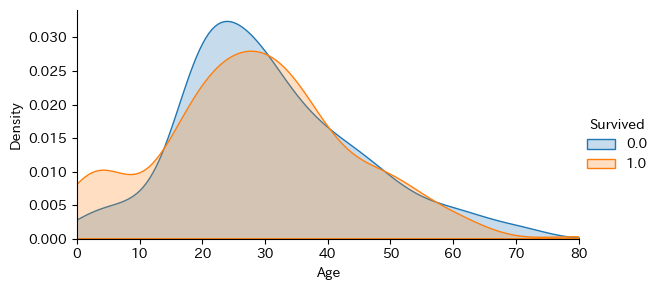

In [100]:

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df_all[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_train.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

# データセットの作成

* 性別は数値でないためOneHotVectorで数値化する

In [101]:
# 性別をベクトル化
df_one = pd.get_dummies(df_train[["Sex"]], dummy_na=False, drop_first=False)
df_one = df_one.astype(np.int64)

df_sex_test = pd.get_dummies(df_test[["Sex"]], dummy_na=False, drop_first=False)
df_sex_test = df_sex_test.astype(np.int64)


In [102]:
# データセット作成
x_train = pd.concat([df_one, df_train[["Pclass", "Fare"]]], axis=1)
y_train = df_train[["Survived"]]
id_train = df_train[["PassengerId"]]

x_test = pd.concat([df_sex_test, df_test[["Pclass", "Fare"]]], axis=1)

# 検証の方針

## 検証データ
* 交差検証を用いる


## モデル
* LightGBMを用いる

# ベースラインの作成

## ハイパーパラメータの探索

### モデルの学習

### 重要度の評価

# モデル推論